# IMPORTANT!
After you have opened connections to the devices via the code on the "... init" sections, you can carry out measurements.

After you are done with your measurments, you need to close the connections to the devices, such that, e.g., other programs can later connect to the devicec (e.g., GUI). 
Just run all cells in the last section "deinitialization".
If you dont close the connection properly, no new connection to the devices can be opened again.

# imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import csv
from datetime import timedelta

# imports conex
import serial
import time
import signal
import sys

# imports qutau
import QuTauBesser # basically the same as QuTau.py provided by qutools but with some improvements, see qutool website
import time

# imports TEC
from TEC_serial_interface import arroyo # "TEC_serial_interface" is identical to the "serial_interface" python file from https://github.com/ArroyoInst/arroyo_tec
import os
import time

Notice: In the quTAU python examples qutools provides, in the "QuTau.py" file the "Counting" functionality is sadly not implemented.
I crated "QuTauBesser" which is identical to "QuTau", but incorporates this functionality, which is implemented like this:

 Counting --------------------------------------------
 
	def getCoincCounters(self):
		data = np.zeros(19, dtype=np.int32)
		update = ctypes.c_int32()

		self.qutools_dll.TDC_getCoincCounters.argtypes = [ctypes.POINTER(ctypes.c_int32), ctypes.POINTER(ctypes.c_int32)]
		self.qutools_dll.TDC_getCoincCounters.restype = ctypes.c_int32

		#ans = self.qutools_dll.TDC_getCoincCounters(data.ctypes.data_as(ctypes.POINTER(ctypes.c_int32)))
		ans = self.qutools_dll.TDC_getCoincCounters(data.ctypes.data_as(ctypes.POINTER(ctypes.c_int32)), ctypes.byref(update)) #alternativ den zweiten parameter einfach 0 setzen

		if (ans!=0): # "never fails"
			print ("Error in TDC_getCoincCounters:"+self.err_dict[ans])
		
		return (data, update.value)

# quTAU init

In [ ]:
# initialize device
qutau = QuTauBesser.QuTau()
devType = qutau.getDeviceType()

if (devType == qutau.DEVTYPE_1A):
	print ("found quTAU!")
elif (devType == qutau.DEVTYPE_1B):
	print ("found quTAU(H)!")
elif (devType == qutau.DEVTYPE_1C):
	print ("found quPSI!")
elif (devType == qutau.DEVTYPE_2A):
	print ("found quTAG!")
else:
	print ("no suitable device found - demo mode activated")
	
print ("Device timebase:" + str(qutau.getTimebase()))
print("setBufferSize: ", qutau.err_dict[qutau.setBufferSize(1000000)])

In [ ]:
# enable channels
# Bitfield with activation flags for every TDC channel. 
qutau.enableChannels((0,1)) 

In [ ]:
qutau.setCoincidenceWindow(150)
qutau.setExposureTime(100)

chn, coinc, exptime = qutau.getDeviceParams()
print("channels: ", bin(chn)) 
# Bitfield with activation flags for every TDC channel. 
# translated to binary for easier readibility 
# (11 = 3 -> channels 1 and 2 activated)
# (101 = 5 -> channels 1 and 3 activated
print("coinc window: ", coinc, "bins")
print("exposure time: ", exptime, "ms")

# conex init

In [23]:
def WaitStatus(agp, val, timeout):       
        #print("WaitStatus : " + val)
        for x in range(timeout):
                time.sleep(0.1)
                cmd = '1TS\r\n' # Get positioner error and controller state
                agp.write(cmd.encode())
                status = agp.readline().decode().rstrip()       
                if val in status:
                        #print("Status = " + status)
                        return 1
        print("WaitStatus timeout, Status = " + status)
        return -1;

In [ ]:
# connect to AGP controller
agp = serial.Serial(port = "COM14", baudrate = 921600, timeout=3)

# reset controller and print version

print("reset controller")

cmd = '1RS\r\n' # Reset controller
agp.write(cmd.encode())
WaitStatus(agp, '1TS00000A', 10000)

cmd = '1VE\r\n' # Get controller revision information
agp.write(cmd.encode())
version = agp.readline().decode().rstrip()
print("Version = " + version)

cmd = '1OR\r\n' # Execute HOME search
agp.write(cmd.encode())
WaitStatus(agp, '1TS000032', 10000)

# If after 1 minute or so the stage is not homing or even finished, there is a problem. 
# Restarting the program that runs this code 
# or connecting to the linear stage via the GUI, reconneecting and trying again with this code did help in the past.

In [ ]:
# get current minimum
cmd = '1SL?\r\n'
agp.write(cmd.encode())
sl = agp.readline().decode().rstrip()
print(sl)

In [120]:
# It should be possible to define a minimum & maximum position for the stage, in order to
# prevent it from moving too far. However, this code here doesnt properly work.

# define minimum
cmd = "1SL0\r\n"
agp.write(cmd.encode())
#WaitStatus(agp, '1TS000033', 10000)
time.sleep(1)

# get current minimum
cmd = '1SL?\r\n' # Get current position
agp.write(cmd.encode())
sl = agp.readline().decode().rstrip()
print(sl)

# TEC init

In [ ]:
# Create an object for the TEC controller which opens up serial com w/ instr.
# The command line interface will print all available arroyo devices in a 
#   number list. Type the number of the instrument you wish to use and hit
#   "enter".
TEC = arroyo()

TEC.set_mode("T")
TEC.set_heatcool("BOTH")
TEC.set_current_limit(1.0)
#TEC.set_voltage_limit(4.0) # Firmware too old

# Set some restrictions on outputs and setpoints
#TEC.set_fan("OFF",1)
TEC.set_TLO_limit(10.0)
TEC.set_THI_limit(75.0)

# Sets tolerance spec for controller
TEC.set_tolerance(0.01, 0.1)

# Sets control type to PID and sets values, tune to your application
TEC.set_gain(3)
#TEC.set_gain("PID")
#TEC.set_PID(32, 0.031, 0)

In [70]:
# A function that lets you set a temperature and that will then wait until the
#  temperature has settled at the target value.

def TEC_set_and_wait(target_temp):
    # Set the system to the target temperature
    TEC.set_temp(target_temp)
    
    start_time = time.time()
    while True:
        current_temp = TEC.read_temp()
        #print(current_temp)
        current_time = time.time()
        
        if current_temp == target_temp:
            # If the temperature has settled at the target value for 2 seconds
            if current_time - start_time >= 2:
                print(f"Temperature settled at {current_temp}°C")
                break
        else:
            # Reset the start time if the temperature is not at the target value
            start_time = current_time
            print(f"Temperature currently at {current_temp}°C")
        
        # Sleep for a short duration before checking again
        time.sleep(0.1)

# measurement

In [43]:
# This is how you get the current count rates from the quTAU
# The last value in the array that is given back, which is here saved in the 
# "update_temp" variable, is the number of "integration cycles" that have been
# performed since the last time the current rates were read out.
data_temp, update_temp = qutau.getCoincCounters()
data_temp

array([ 8308, 10242,     0,     0,     0,     0,     0,     0,   107,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [ ]:
# move linear stage to point
point = 2.9
cmd = "1PA"+str(point)+"\r\n" # Move absolute
agp.write(cmd.encode())
WaitStatus(agp, '1TS000033', 10000)
cmd = '1TP\r\n' # Get current position
agp.write(cmd.encode())
position = agp.readline().decode().rstrip()
print("Position = " + position)

In [ ]:
# move linear stage in relative steps
cmd = "1PR-0.01\r\n" # Move relative
agp.write(cmd.encode())
WaitStatus(agp, '1TS000033', 10000)
cmd = '1TP\r\n' # Get current position
agp.write(cmd.encode())
position = agp.readline().decode().rstrip()
print("Position = " + position)

# measurement HOM

In [ ]:
# set temperature
temp = 45.3 #°C
TEC_set_and_wait(temp)

In [ ]:
# define parameters
qutau.setCoincidenceWindow(150) # bins
start_point = 1.5 # mm
step_size = 0.1 # mm
num_points = int(31) # how often shall the stage move in steps of step_size?
measurements_per_point = 20
HWP = 90 # deg
free_space_filter = 1 # 0 means no filter, 1 means filter
laser_diode_curr = 200 # mA


# print for visual double check of set paramters
center_point = start_point+step_size*(num_points-1)/2
print("Measurement region:", start_point, "-", start_point+step_size*(num_points-1), "mm")
print("Center:", center_point, "mm")
print("Step size:", step_size,"mm"), 
print("Measurements per point:",measurements_per_point)
print("Exposure time: ", exptime, "ms")
print("laser_diode_curr:", laser_diode_curr)
print("free_space_filter:", free_space_filter)
td = timedelta(seconds=num_points*measurements_per_point/10)
print('This measurement will take ca.', td)

if center_point < 2.5 or center_point > 3.5:
    print("!!!*****   ARE YOU SURE THAT YOU WANT TO MEASURE WITH A CENTER POINT OF",center_point,"mm !?!?!?!?!   *****!!!")

In [290]:
# this can be used to add a for loop to othe measurement code below in order
# to repeat the measurement several times for different temperatures

#temp_start = 44.4
#temp_end = 46.4
#temp_step = 0.1
#np.arange(temp_start, temp_end + temp_step, temp_step)

#for temp in np.arange(46.3, temp_end + temp_step, temp_step):

    #TEC_set_and_wait(temp)

In [ ]:
# list of filenames, in case this whole code is run multiple times (e.g., in the for loop above)
#filenames = []

# create array to hold data
data = np.zeros((num_points*measurements_per_point,5))

# move linear stage to start point
cmd = "1PA"+str(start_point)+"\r\n" # Move absolute
agp.write(cmd.encode())
WaitStatus(agp, '1TS000033', 10000)
cmd = '1TP\r\n' # Get current position
agp.write(cmd.encode())
position = agp.readline().decode().rstrip()
print("Position = " + position)

# Iteratively move relative the step size
for i in range (num_points):
    #start = time.time()
    cmd = "1PR"+str(step_size)+"\r\n" # Move relative
    agp.write(cmd.encode())
    WaitStatus(agp, '1TS000033', 10000)
    cmd = '1TP\r\n' # Get current position
    agp.write(cmd.encode())
    position = agp.readline().decode().rstrip()
    print("Position = " + position)
    #print("It took", time.time()-start, "seconds for the repositioning".)

    # Iteratively get the coinc and wait the exposure time
    for j in range(measurements_per_point):
        #start = time.time()
        data_temp, update_temp = qutau.getCoincCounters()
        data_temp = data_temp[[0,1,8]] * 1000/exptime
        data_temp = np.append(data_temp, update_temp)
        pos_temp = start_point + i * step_size
        data[i * measurements_per_point + j] = np.append(pos_temp,data_temp)
        #print(update_temp)
        time.sleep(exptime/1000.0)
        #print("It took", time.time()-start, "seconds for the measurement".)


# Save the data, metadata and phases to csv files

# Generate a date and time tag for the filename
date_time_tag = datetime.now().strftime('%Y%m%d_%H%M%S')

file_name_data = f'{date_time_tag}_I{laser_diode_curr}_data.csv'
np.savetxt(file_name_data, data, delimiter=',')
#filenames.append(file_name_data)

metadata = np.array([["start_point", "step_size", "num_points", "measurements_per_point", "exptime", "coinc", "laser_diode_curr","free_space_filter","temp","HWP"],
            [start_point, step_size, num_points, measurements_per_point, exptime, coinc, laser_diode_curr, free_space_filter,temp,HWP]])
file_name_metadata = f'{date_time_tag}_metadata.csv'
with open(file_name_metadata, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(metadata)

#np.save(f'{date_time_tag}_temperature_filenames.npy', filenames)

# analysis and plotting

In [295]:
# Finding unique values in col 1 (positions)
pos = np.unique(data[:, 0])

# Calculating mean and standard deviation for col 2, 3, and 4 (singles & coinc)
# based on values in column 1 (positions)

# notice: using a dict may be cumbersome here, the main reason why I used it is
# that I wanted to learn how to properly use dicts... :)
data_dict = {}
for position in pos:
    mask = data[:, 0] == position
    mean_values = data[mask, 1:4].mean(axis=0)
    std_values = data[mask, 1:4].std(axis=0)
    data_dict[position] = {'mean': mean_values, 'std': std_values}

#result

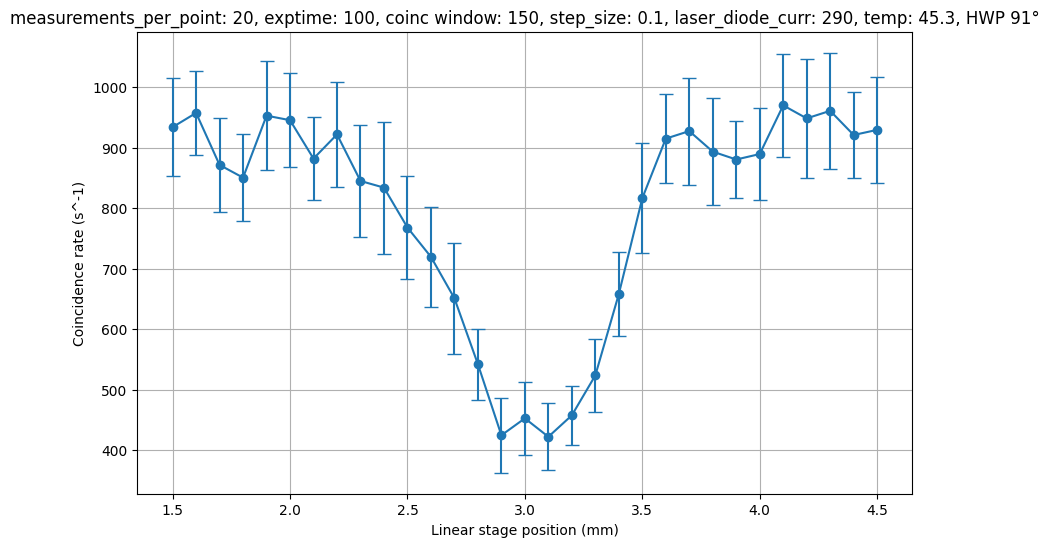

In [297]:
# Extracting mean values of coinc (col 4) and unique values from result
coinc_mean = [value['mean'][2] for value in data_dict.values()]

# Extracting standard deviation values of coinc (col 4) for error bars
coinc_std = [value['std'][2] for value in data_dict.values()]

# Plotting with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(pos, coinc_mean, yerr=coinc_std, marker='o', linestyle='-', capsize=5)#, label="Mean of Column 4")
plt.title("measurements_per_point: "+ str(measurements_per_point) + ", exptime: " + str(exptime) + ", coinc window: " + str(coinc) 
                    + ", step_size: " + str(step_size) + ", laser_diode_curr: " + str(laser_diode_curr) + ", temp: " + str(temp) + ", HWP " + str(HWP) +"°")
plt.xlabel("Linear stage position (mm)")
plt.ylabel("Coincidence rate (s^-1)")
#plt.legend()
plt.grid(True)
plt.show()

# coincidence window change
In order to find out at which bin size of the coincidence window the coincidence rate jumps up and we thus know, that the coincidence window incorporates the "real" coincidences caused by two photons from the same SPDC pair, the coincidence window is simply increased and each step the rate is measured. 

In [ ]:
measurements_per_point = 20

# create array to hold data
data = np.zeros((51*measurements_per_point,5))

# move linear stage to start point
cmd = "1PA"+str(start_point)+"\r\n" # Move absolute
agp.write(cmd.encode())
WaitStatus(agp, '1TS000033', 10000)
cmd = '1TP\r\n' # Get current position
agp.write(cmd.encode())
position = agp.readline().decode().rstrip()
print("Position = " + position)

k = 0

# Iteratively change coinc window
for i in np.arange(120,171,1):
    qutau.setCoincidenceWindow(i)
    time.sleep(1)
    
    # Iteratively get the coinc and wait the exposure time
    for j in range(measurements_per_point):
        #start = time.time()
        data_temp, update_temp = qutau.getCoincCounters()
        data_temp = data_temp[[0,1,8]] * 1000/exptime
        data_temp = np.append(data_temp, update_temp)
        #pos_temp = start_point + i * step_size
        data[k * measurements_per_point + j] = np.append(i,data_temp)
        #print(update_temp)
        time.sleep(exptime/1000.0)
        #print("It took", time.time()-start, "seconds for the measurement".)

    k += 1

# Save the data, metadata and phases to csv files

# Generate a date and time tag for the filename
date_time_tag = datetime.now().strftime('%Y%m%d_%H%M%S')

file_name_data = f'{date_time_tag}_data.csv'
np.savetxt(file_name_data, data, delimiter=',')


metadata = np.array([["start_point", "step_size", "num_points", "measurements_per_point", "exptime", "coinc", "laser_diode_curr","free_space_filter","temp","HWP"],
            [start_point, step_size, num_points, measurements_per_point, exptime, coinc, laser_diode_curr, free_space_filter,temp,HWP]])
file_name_metadata = f'{date_time_tag}_metadata.csv'
#np.savetxt(file_name_metadata, metadata, delimiter=',')
with open(file_name_metadata, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(metadata)

In [ ]:
# Finding unique values in col 1 (coinc_window)
coincidence_window = np.unique(data[:, 0])

# Calculating mean and standard deviation for col 2, 3, and 4 (singles & coinc)
# based on values in column 1 (coinc_window)
data_dict = {}
for coinc_window in coincidence_window:
    mask = data[:, 0] == coinc_window
    mean_values = data[mask, 1:4].mean(axis=0)
    std_values = data[mask, 1:4].std(axis=0)
    data_dict[coinc_window] = {'mean': mean_values, 'std': std_values}

# Extracting mean values of coinc (col 4) and unique values from result
coinc_mean = [value['mean'][2] for value in data_dict.values()]
#unique_vals_col1 = list(result.keys())

# Extracting standard deviation values of coinc (col 4) for error bars
coinc_std = [value['std'][2] for value in data_dict.values()]

# Plotting with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(coincidence_window, coinc_mean, yerr=coinc_std, marker='o', linestyle='-', capsize=5)#, label="Mean of Column 4")
plt.title("measurements_per_point: "+ str(measurements_per_point) + ", exptime: " + str(exptime) + ", coinc window: " + str(coinc) 
                    + ", step_size: " + str(step_size) + ", laser_diode_curr: " + str(laser_diode_curr) + ", temp: " + str(temp) + ", HWP " + str(HWP) +"°")
plt.xlabel("coincidence_window")
plt.ylabel("Coincidence rate (s^-1)")
#plt.legend()
plt.grid(True)
plt.show()

# Background coinc
As sadly with the quTAU only the maximum of the coincidence window can be set, a lot of "false" (or background) coincidences is measured together with the "real" coincidences we are interested in. Here, these "false" coincidences where identified by simply lowering the coincidence window to a number of bins where only "false" coincidences are registered.
This measurement is taken outside of the HOM dip, but actually I think it doesnt have to...?

In [ ]:
qutau.setCoincidenceWindow(120)

#laser_diode_curr = 110

# measurement on one point (where only a single measurement is taken)
point_single = 5
measurements_per_point_single = 100

# create array to hold data
data = np.zeros((measurements_per_point_single,5))

# move linear stage to  point
cmd = "1PA"+str(point_single)+"\r\n" # Move absolute
agp.write(cmd.encode())
WaitStatus(agp, '1TS000033', 10000)
cmd = '1TP\r\n' # Get current position
agp.write(cmd.encode())
position = agp.readline().decode().rstrip()
print("Position = " + position)


# Iteratively get the coinc and wait the exposure time
for j in range(measurements_per_point_single):
    #start = time.time()
    data_temp, update_temp = qutau.getCoincCounters()
    data_temp = data_temp[[0,1,8]] * 1000/exptime
    data_temp = np.append(data_temp, update_temp)
    pos_temp = point_single
    data[j] = np.append(pos_temp,data_temp)
    #print(update_temp)
    time.sleep(exptime/1000.0)
    #print("It took", time.time()-start, "seconds for the measurement".)


# Save the data, metadata and phases to csv files

# Generate a date and time tag for the filename
date_time_tag = datetime.now().strftime('%Y%m%d_%H%M%S')

file_name_data = f'{date_time_tag}_single_point_data_I{laser_diode_curr}.csv'
np.savetxt(file_name_data, data, delimiter=',')

metadata = np.array([["point_single", "measurements_per_point_single", "exptime", "coinc", "laser_diode_curr","free_space_filter","temp", "HWP"],
            [point_single, measurements_per_point_single, exptime, coinc, laser_diode_curr, free_space_filter,temp, HWP]])
file_name_metadata = f'{date_time_tag}_single_point_metadata.csv'
#np.savetxt(file_name_metadata, metadata, delimiter=',')
with open(file_name_metadata, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(metadata)

# SPDC pre

In [71]:
temp = 45.24 #°C
TEC_set_and_wait(temp)

Updated set point to: 45.24°C
Temperature settled at 45.24°C


In [102]:
laser_diode_curr = 290

# measurement on one point
#point_single = 4.1
measurements_per_point_single = 100


# create array to hold data
data = np.zeros((measurements_per_point_single,4))

# move linear stage to  point
#cmd = "1PA"+str(point_single)+"\r\n" # Move absolute
#agp.write(cmd.encode())
#WaitStatus(agp, '1TS000033', 10000)
#cmd = '1TP\r\n' # Get current position
#agp.write(cmd.encode())
#position = agp.readline().decode().rstrip()
#print("Position = " + position)


# Iteratively get the coinc and wait the exposure time
for j in range(measurements_per_point_single):
    #start = time.time()
    data_temp, update_temp = qutau.getCoincCounters()
    data_temp = data_temp[[0,1,8]] * 1000/exptime
    data_temp = np.append(data_temp, update_temp)
    #pos_temp = point_single
    data[j] = data_temp
    #print(update_temp)
    time.sleep(exptime/1000.0)
    #print("It took", time.time()-start, "seconds for the measurement".)


# Save the data, metadata and phases to csv files

# Generate a date and time tag for the filename
date_time_tag = datetime.now().strftime('%Y%m%d_%H%M%S')

file_name_data = f'{date_time_tag}_single_point_data_{laser_diode_curr}.csv'
np.savetxt(file_name_data, data, delimiter=',')

metadata = np.array([["measurements_per_point_single", "exptime", "coinc", "laser_diode_curr","temp"],
            [measurements_per_point_single, exptime, coinc, laser_diode_curr  ,temp]])
file_name_metadata = f'{date_time_tag}_single_point_metadata.csv'
#np.savetxt(file_name_metadata, metadata, delimiter=',')
with open(file_name_metadata, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(metadata)

#file_name_phases_HOM = f'{date_time_tag}_single_point_phases.csv'
#np.savetxt(file_name_phases_HOM, phases_HOM, delimiter=',')

# deinitialization

In [61]:
# deinitialize quTAU
qutau.deInitialize()

0

In [ ]:
# deinitialize conex linear stage, but before that, move it to a safe position

# move linear stage to  point
cmd = "1PA"+str(9)+"\r\n" # Move absolute
agp.write(cmd.encode())
WaitStatus(agp, '1TS000033', 10000)
cmd = '1TP\r\n' # Get current position
agp.write(cmd.encode())
position = agp.readline().decode().rstrip()
print("Position = " + position)

print("")
print("DONT FORGET TO PUT THE HWP AWAY!!!!!!")

# background: In some setups, the HWP can be in a position where it will be "hit" 
# by the collimator on the part of the linear stage that is moving, when the 
# linear stage is homing (aka moving to the 0 position). This can damage the HWP. 
# So in these situations, after the measurement, the HWP should be moved away 
# after the measurements are done, such that the collimator wont damage the HWP
# when you want to start a measurement and the linear stage is homing as part of its initalization.

# close conex port
agp.close()

In [ ]:
# deinitalize TEC
TEC.close()